# **Pneumonia Detection**
**A machine learning project for detecting pneumonia from chest X-ray images. It includes data preprocessing, feature extraction, and performance evaluation to aid early diagnosis.**

## **Traditional Model Tuning**

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import ClassifierMixin
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

KFOLD = 5

In [2]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(
  estimator: ClassifierMixin, X_train: np.ndarray, y_train: np.ndarray, ax: Axes
):
  _, train_scores, test_scores, _, _ = learning_curve(
    estimator, X_train, y_train, cv=KFOLD, n_jobs=-1, return_times=True
  )

  train_sizes = np.linspace(0.1, 1.0, 5)

  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  # Plot learning curve
  ax.grid()
  ax.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
  )
  ax.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
  )
  ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
  ax.plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
  )
  ax.legend(loc="best")
  plot_title = f"{type(estimator).__name__} Learning Curve"
  ax.set_title(plot_title)


In [3]:
from sklearn.model_selection import GridSearchCV


def plot_gridsearch_results(grid: GridSearchCV, estimator: ClassifierMixin, ax: Axes):
  results = pd.DataFrame(grid.cv_results_)
  plot_cols = [col for col in results.columns if "split" in col and "test" in col]
  results = results[plot_cols].mean(axis=1).sort_values(ascending=False)
  plot_title = f"{type(estimator).__name__} GridSearch Result"

  ax.bar(
    range(len(results)),
    results,
    align="center",
    alpha=0.8,
    color="skyblue",
  )
  ax.set_ylabel("Mean Test Score")
  ax.set_xlabel(f"Best = {grid.best_params_}", fontsize=8)
  ax.set_title(plot_title)

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_confusion_matrix(
  estimator: ClassifierMixin, y_test: np.ndarray, y_guess: np.ndarray, ax: Axes
):
  disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_guess))
  disp.plot(ax=ax, cmap=plt.cm.Blues)
  plot_title = f"{type(estimator).__name__} Confusion Matrix"
  disp.ax_.set_title(plot_title)

In [5]:
from sklearn.metrics import roc_curve, auc


def plot_aucroc_curve(
  estimator: ClassifierMixin, X_test: np.ndarray, y_test: np.ndarray, ax: Axes
):
  y_pred_proba = estimator.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
  roc_auc = auc(fpr, tpr)
  pd.DataFrame({"fpr": fpr, "tpr": tpr}).plot(
    "fpr",
    "tpr",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    label=f"AUC = {roc_auc:.3f}",
    xlim=[0.0, 1.0],
    ylim=[0.0, 1.05],
    grid=True,
    title=f"{type(estimator).__name__} AUC-ROC Curve",
    ax=ax,
  )
  ax.plot([0, 1], [0, 1], color="gray", linestyle="--")
  ax.legend(loc="lower right")

In [6]:
from sklearn.metrics import precision_recall_curve, average_precision_score


def plot_prcrcl_curve(
  estimator: ClassifierMixin, X_test: np.ndarray, y_test: np.ndarray, ax: Axes
):
  y_pred_proba = estimator.predict_proba(X_test)[:, 1]
  precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
  avg_precision = average_precision_score(y_test, y_pred_proba)
  pd.DataFrame({"recall": recall, "precision": precision}).plot(
    "recall",
    "precision",
    xlabel="Recall",
    ylabel="Precision",
    label=f"AP = {avg_precision:.3f}",
    xlim=[0.0, 1.0],
    ylim=[0.0, 1.05],
    grid=True,
    title=f"{type(estimator).__name__} Precision-Recall Curve",
    ax=ax,
  )
  ax.plot([0, 1], [1, 0], color="gray", linestyle="--")
  ax.legend(loc="lower right")


In [7]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold


def eval_clf(
  clf: ClassifierMixin,
  grid: dict,
  X_train: np.ndarray,
  y_train: np.ndarray,
  X_test: np.ndarray,
  y_test: np.ndarray,
  axes: np.ndarray,
) -> list:
  cv = StratifiedKFold(n_splits=KFOLD, shuffle=True, random_state=42)
  grid_search = GridSearchCV(
    clf,
    grid,
    scoring=make_scorer(f1_score),
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
  )

  grid_search.fit(X_train, y_train)
  best_clf = grid_search.best_estimator_
  plot_learning_curve(best_clf, X_train, y_train, axes[0])
  # plot_gridsearch_results(grid_search, best_clf, axes[1])
  y_guess = best_clf.predict(X_test)
  plot_confusion_matrix(best_clf, y_test, y_guess, axes[1])
  plot_aucroc_curve(best_clf, X_test, y_test, ax=axes[2])
  plot_prcrcl_curve(best_clf, X_test, y_test, ax=axes[3])

  return [
    f1_score(y_test, y_guess),
    precision_score(y_test, y_guess),
    recall_score(y_test, y_guess),
  ]

In [8]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

recipes = [
  (
    SVC(probability=True, random_state=42),
    {
      "C": [0.1, 1, 10, 100],
      "kernel": ["linear", "rbf", "poly", "sigmoid"],
      "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],
      "degree": [2, 3, 4],  # Only used with the 'poly' kernel
      "coef0": [0.0, 0.1, 0.5, 1],  # Only used with 'poly' or 'sigmoid' kernels
    },
  ),
  (
    DecisionTreeClassifier(random_state=42),
    {
      "criterion": ["gini", "entropy"],  # Options for impurity measure
      "max_depth": [None, 5, 10, 20, 30],  # Maximum depth of the tree
      # Minimum number of samples required to split an internal node
      "min_samples_split": [2, 5, 10, 20],
      # Minimum number of samples required to be at a leaf node
      "min_samples_leaf": [1, 2, 4, 6],
      # Number of features to consider when looking for the best split
      "max_features": [None, "sqrt", "log2"],
    },
  ),
  (
    KNeighborsClassifier(),
    {
      "n_neighbors": list(range(1, 31)),  # Try neighbors from 1 to 30
      "weights": ["uniform", "distance"],  # Uniform weights or distance-based weighting
      # Algorithm to compute nearest neighbors
      "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
      "leaf_size": [10, 20, 30, 40, 50],  # Leaf size for tree-based algorithms
      "p": [1, 2],  # p=1 for Manhattan distance, p=2 for Euclidean distance
    },
  ),
  (
    GaussianNB(),
    {
      "var_smoothing": np.logspace(-9, -1, num=9)  # Explore values from 1e-9 to 1e-1
    },
  ),
  (
    LogisticRegression(random_state=42),
    {
      "penalty": ["l1", "l2"],  # Regularization type
      # Inverse of regularization strength; smaller values specify stronger regularization
      "C": [0.1, 1, 10, 100],
      "solver": ["liblinear", "saga"],  # Solvers that support both l1 and l2 penalties
      "max_iter": [100, 200, 300],  # Maximum number of iterations for convergence
    },
  ),
  (
    RandomForestClassifier(random_state=42),
    {
      "n_estimators": [100, 200, 300],  # Number of trees in the forest.
      "max_depth": [None, 10, 20, 30],  # Maximum depth of each tree.
      # Minimum number of samples required to split an internal node.
      "min_samples_split": [2, 5, 10],
      # Minimum number of samples required to be at a leaf node.
      "min_samples_leaf": [1, 2, 4],
      # Number of features to consider when looking for the best split.
      "max_features": ["sqrt", "log2", None],
      # Whether bootstrap samples are used when building trees.
      "bootstrap": [True, False],
    },
  ),
  (
    AdaBoostClassifier(random_state=42),
    {
      "n_estimators": [50, 100, 200],  # Number of weak learners (estimators)
      # Weight applied to each classifier at each boosting iteration
      "learning_rate": [0.01, 0.1, 1, 10],
    },
  ),
  (
    XGBClassifier(eval_metric="logloss", random_state=42),
    {
      "n_estimators": [50, 100, 200],  # Number of boosting rounds
      "max_depth": [3, 5, 7],  # Maximum depth of a tree
      # Step size shrinkage used in update to prevent overfitting
      "learning_rate": [0.01, 0.1, 0.2],
      "subsample": [0.8, 1.0],  # Subsample ratio of the training instances
      # Subsample ratio of columns when constructing each tree
      "colsample_bytree": [0.8, 1.0],
      "reg_alpha": [0, 0.1, 1],  # L1 regularization term on weights
      "reg_lambda": [1, 1.5, 2],  # L2 regularization term on weights
    },
  ),
]

SVC


/opt/miniconda3/envs/CS6220/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/CS6220/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/envs/CS6220/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/CS6220/lib/python3.12/site-packages/sklearn/svm/

DecisionTreeClassifier
KNeighborsClassifier
GaussianNB
LogisticRegression


/opt/miniconda3/envs/CS6220/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/CS6220/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/CS6220/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/CS6220/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/CS6220/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/CS6220/lib/python3.

RandomForestClassifier
AdaBoostClassifier
XGBClassifier


/opt/miniconda3/envs/CS6220/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/CS6220/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/envs/CS6220/lib/python3.12/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/CS6220/lib/python3.12/site-packages/xgboost/sklearn.py", line 1640, in fit
    raise ValueError(


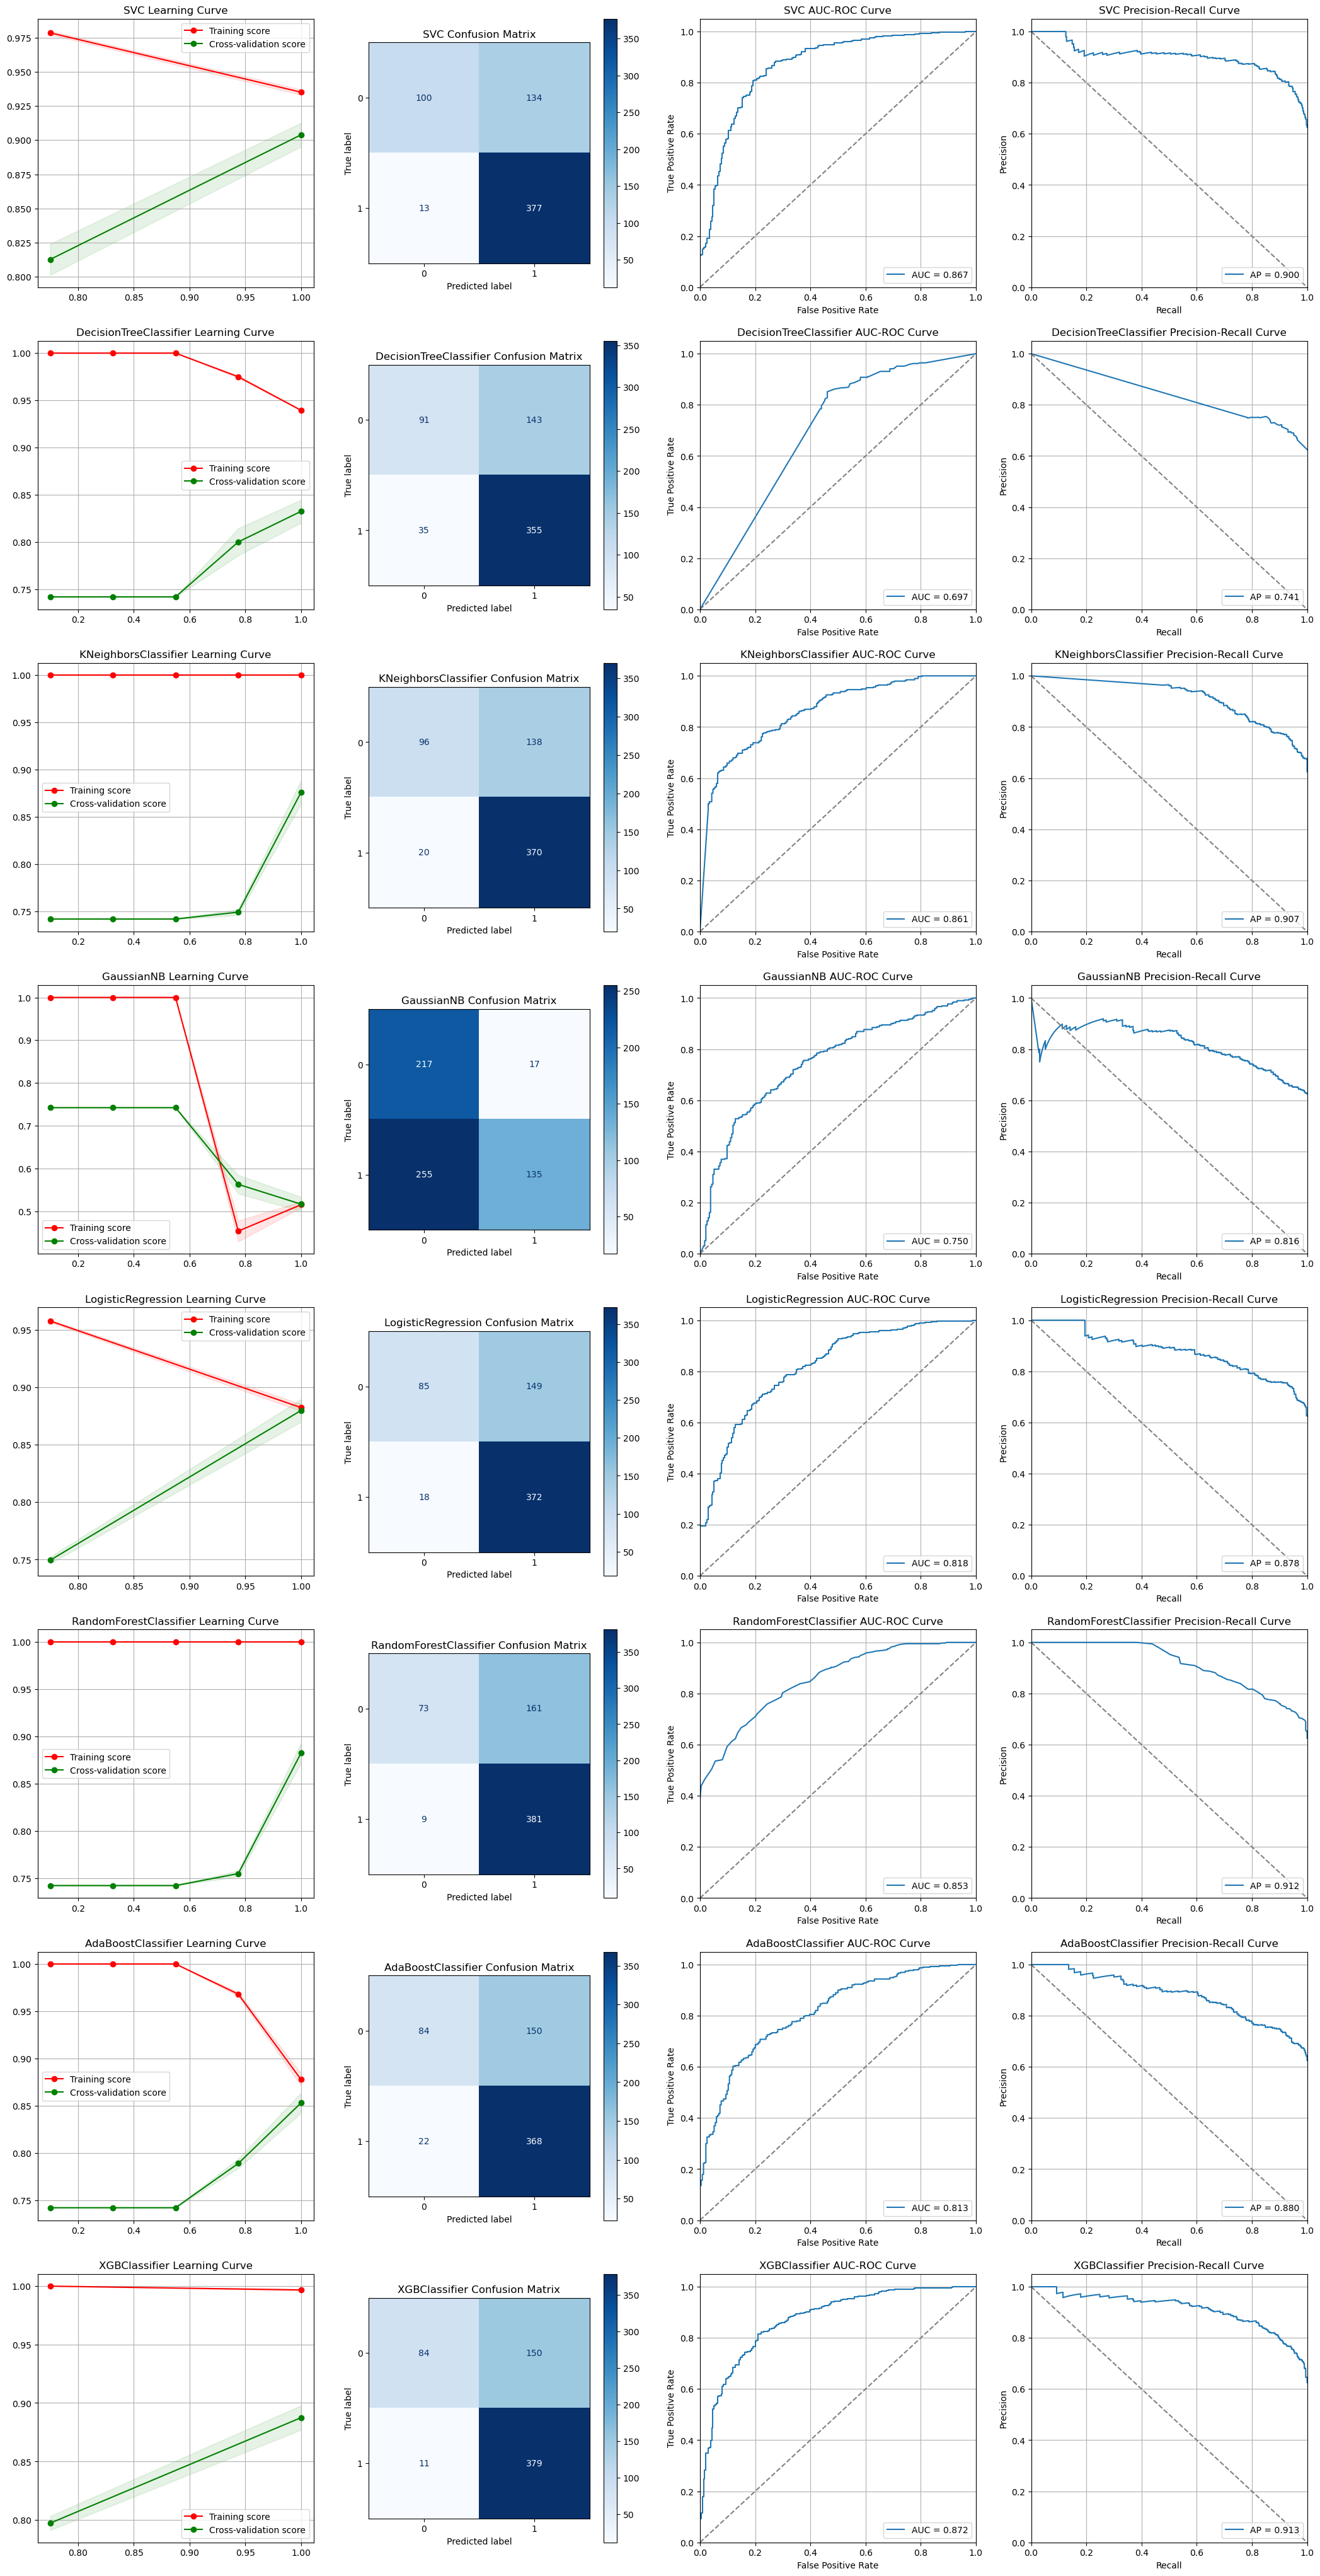

In [9]:
from _data import load_pneumonia

fig, axs = plt.subplots(len(recipes), 4, figsize=(26, 6.5 * len(recipes)))
train, test = load_pneumonia(
  include_raw=False, include_hog=False, include_lbp=True, pca_mode="none"
)
X_train, y_train = np.split(train, [-1], axis=1)
X_test, y_test = np.split(test, [-1], axis=1)
test_score = pd.DataFrame(columns=["F1", "Precision", "Recall"])
for index, (clf, grid) in enumerate(recipes):
  print(type(clf).__name__)
  test_score.loc[type(clf).__name__] = eval_clf(
    clf, grid, X_train, y_train.flatten(), X_test, y_test.flatten(), axs[index, :]
  )
plt.show()

<Axes: title={'center': 'Testing Set Performance by Model'}>

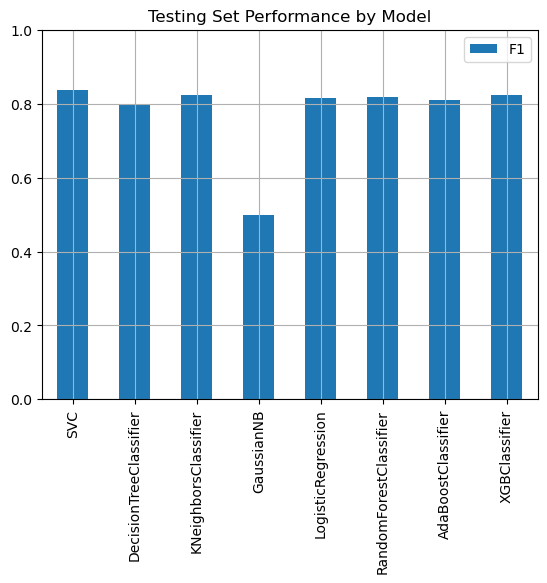

In [ ]:
test_score.plot.bar(
  y="F1",
  use_index=True,
  ylim=[0.0, 1.0],
  grid=True,
  title="Testing Set Performance by Model",
)